<h1 style="font-size:350%;text-align:center;border-radius: 50px 50px;padding: 15px;color:black;">Urban Sound Classification using Deep Learning</h1>

![](https://miro.medium.com/max/1400/1*7YbBTqwF2dMAuQwOrD_hXQ.png)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout

In [2]:
path_ = '../input/urbansound8k/'
path_csv = path_+'UrbanSound8K.csv'
data = pd.read_csv(path_csv)
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [4]:
data.describe()

fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000

In [5]:
data.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [6]:
data['file_path'] = path_+'fold'+data.fold.astype(str)+'/'+data['slice_file_name']
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                       file_path  
0          dog_bark    ../input/urbansound8k/fold5/100032-3-0-0.wav  
1  children_playing  ../input/urbansound8k/fold5/100263-2-0-117.wav  
2  children_playing  ../input/urbansound8k/fold5/100263-2-0-121.wav  
3  children_playing  ../input/urbansound8k/fold5/100263-2-0-126.wav  
4  children_playing  ../input/urbansound8k/fold5/100263-2-0-137.wav

In [7]:
df = data[['file_path','class']]
df.head()

file_path             class
0    ../input/urbansound8k/fold5/100032-3-0-0.wav          dog_bark
1  ../input/urbansound8k/fold5/100263-2-0-117.wav  children_playing
2  ../input/urbansound8k/fold5/100263-2-0-121.wav  children_playing
3  ../input/urbansound8k/fold5/100263-2-0-126.wav  children_playing
4  ../input/urbansound8k/fold5/100263-2-0-137.wav  children_playing

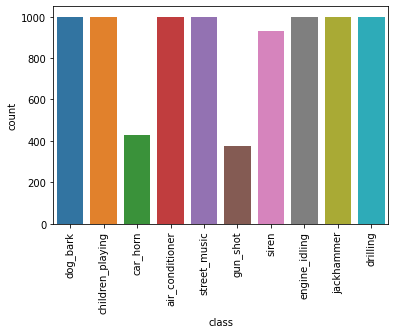

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [8]:
sns.countplot(x='class', data=df)
plt.xticks(rotation=90);
plt.show()
df['class'].value_counts()

In [9]:
df.columns

Index(['file_path', 'class'], dtype='object')

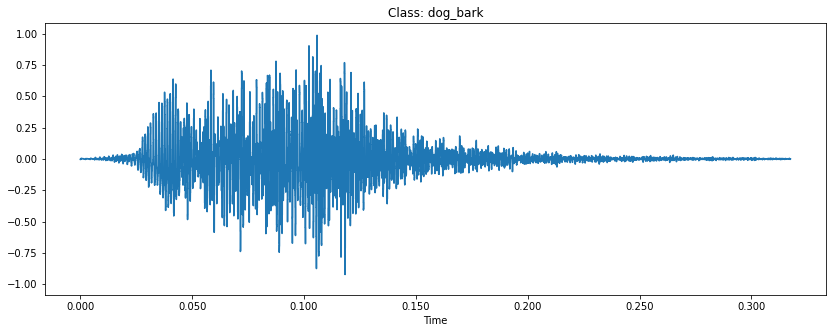

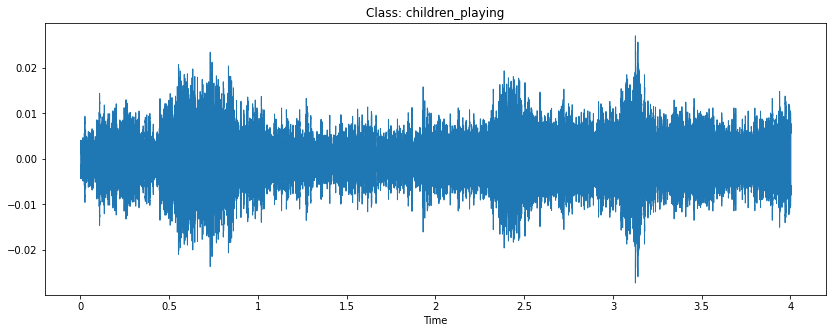

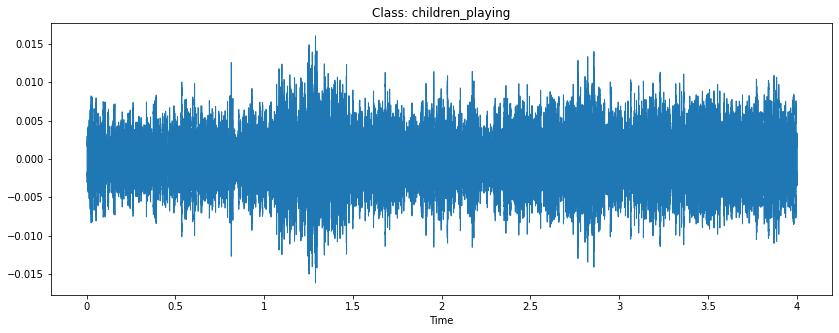

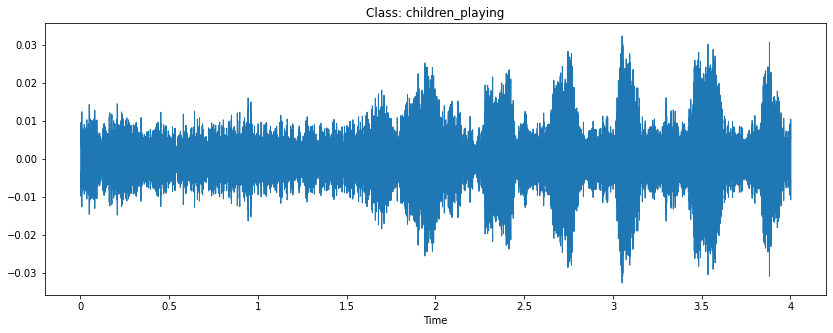

In [10]:
for i in range(4):
    x, sr = librosa.load(df.file_path[i])
    plt.figure(figsize=(14,5))
    plt.title('Class: '+str(df['class'][i]))
    librosa.display.waveshow(x, sr=sr)

In [11]:
from scipy.io import wavfile as wav
import IPython.display as ipd
ipd.Audio('../input/urbansound8k/fold5/100263-2-0-117.wav')

In [12]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    return mfccs_processed

In [13]:
features = []
for index, row in df.iterrows():
    file_name = str(row['file_path'])
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])  

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [14]:
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [15]:
featuresdf.head()

feature       class_label
0  [-218.18938, 71.38549, -131.49442, -52.25892, ...          dog_bark
1  [-425.05234, 110.67095, -54.192833, 62.045414,...  children_playing
2  [-459.82623, 122.82864, -47.908062, 53.302677,...  children_playing
3  [-414.82184, 102.94826, -36.656853, 54.170742,...  children_playing
4  [-447.60776, 115.08627, -53.74607, 61.55309, 1...  children_playing

In [16]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

In [17]:
X.shape, y.shape

((8732, 40), (8732,))

In [18]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [20]:
x_train.shape[1]

40

In [21]:
model = Sequential()
model.add(Dense(64, input_dim=40,  activation='relu'))
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2624      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
_________________________________________________________________
dropout (Dropout)            (None, 46)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                940       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 6,764
Trainable params: 6,764
Non-trainable params: 0
_________________________________________________________________


2022-06-25 15:50:06.241387: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [23]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[earlystop], epochs=100)

2022-06-25 15:50:06.617788: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
219/219 [==============================] - 2s 4ms/step - loss: 5.5389 - accuracy: 0.1098 - val_loss: 2.2893 - val_accuracy: 0.1294
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 2.6295 - accuracy: 0.1261 - val_loss: 2.2788 - val_accuracy: 0.1271
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.4327 - accuracy: 0.1327 - val_loss: 2.2560 - val_accuracy: 0.1339
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 2.3520 - accuracy: 0.1432 - val_loss: 2.2413 - val_accuracy: 0.1374
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 2.3054 - accuracy: 0.1473 - val_loss: 2.2272 - val_accuracy: 0.1448
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 2.2666 - accuracy: 0.1525 - val_loss: 2.2056 - val_accuracy: 0.1563
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 2.2385 - accuracy: 0.1642 - val_loss: 2.1661 - val_accuracy: 0.1746

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

In [25]:
print("Training Accuracy: %.2f%%" % accuracy)

Training Accuracy: 73.50%


In [26]:
# Evaluating The Model
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 76.26%
Testing Accuracy: 73.50%


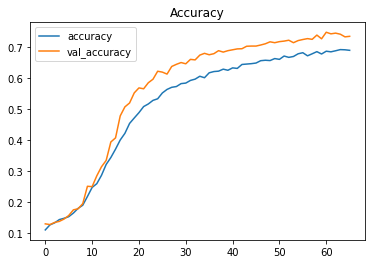

In [27]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

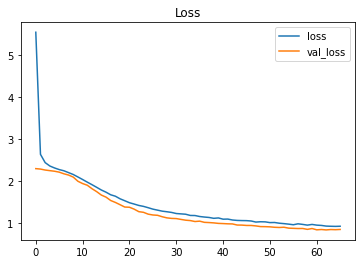

In [28]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [29]:
def prediction_(path_sound):
    data_sound = extract_features(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1,40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_,axis=1)
    pred_class = le.inverse_transform(pred_)
    print("The predicted class is:\033[01m ", pred_class[0],'\033[0m \n')

In [30]:
path_sound = '../input/urbansound8k/fold5/100263-2-0-117.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

The predicted class is:  children_playing  



In [31]:
path_sound = '../input/urbansound8k/fold8/106905-5-0-0.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

The predicted class is:  children_playing  



In [32]:
path_sound = '../input/urbansound8k/fold1/103074-7-1-0.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

The predicted class is:  jackhammer  

